In [110]:
import numpy as np
import numpy.ma as ma

from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import ndimage
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.nddata import bitmask
from astropy.nddata.bitmask import BitFlagNameMap
import math
from tqdm import tqdm

import copy

from scipy.ndimage import gaussian_filter1d

from sympy.interactive import printing
printing.init_printing(use_latex = True)

In [111]:
import os
current_directory = os.getcwd()
print(current_directory)

/global/u1/j/jlargett/DESI_SGA/Morphology


In [112]:
#SGA_Param_Data = Table.read('SGA_Asym_Data.fits')
SGA_Param_Data = Table.read('SGA_M20_Data1.fits')
SGA_Param_Data

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z,GINI_G,GINI_R,GINI_Z,Asymmetry_G,Asymmetry_R,Asymmetry_Z,M20_G,M20_R,M20_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.004

In [161]:
# Path to a random image in NERSC
f1 = math.trunc(SGA_Param_Data['RA'][1])
f2 = math.trunc((1000*SGA_Param_Data['RA'][1]))
f3 = math.trunc((100000*SGA_Param_Data['RA'][1]))
f4 = 'm' if SGA_Param_Data['DEC'][1] < 0 else 'p'
f5 = abs(math.trunc((100000*SGA_Param_Data['DEC'][1])))
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/222/222749/22274970p1386192.fits'
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/188/188533/18853364p4559562.fits'
path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/182/182088/18208882p2560226.fits'
fits_file = fits.open(path)
image = fits_file[0].data
bit_mask = fits_file[1].data

In [162]:
print(f"Image Shape: {image.shape}")
print(f"Bitmask Shape: {bit_mask.shape}")

Image Shape: (3, 303, 303)
Bitmask Shape: (303, 303)


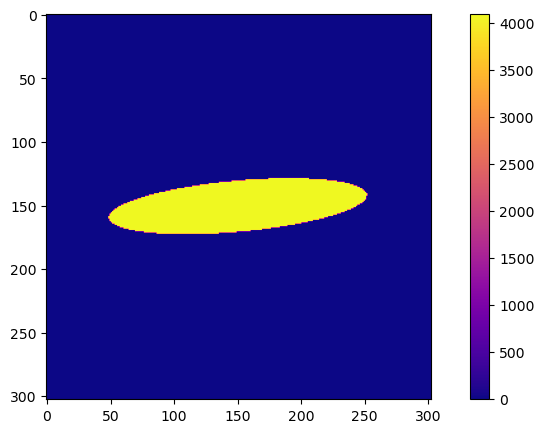

In [163]:
# Showing image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(bit_mask, cmap='plasma')
plt.colorbar()

In [164]:
# Reshape the data
if image.shape[0] == 3:
    image_data = np.transpose(image, (1, 2, 0))
print(f"Image Shape: {image_data.shape}")

Image Shape: (303, 303, 3)


In [165]:
fits_file.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


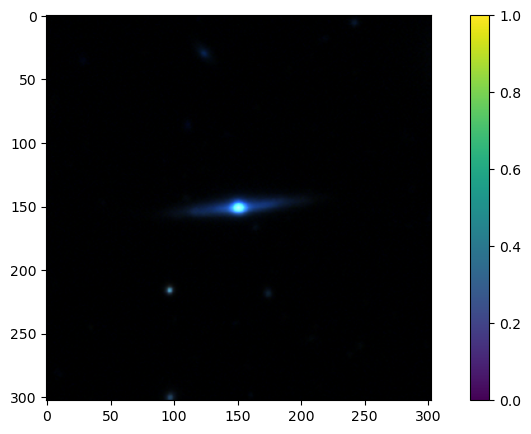

In [166]:
# Showing normal image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(image_data)
plt.colorbar()

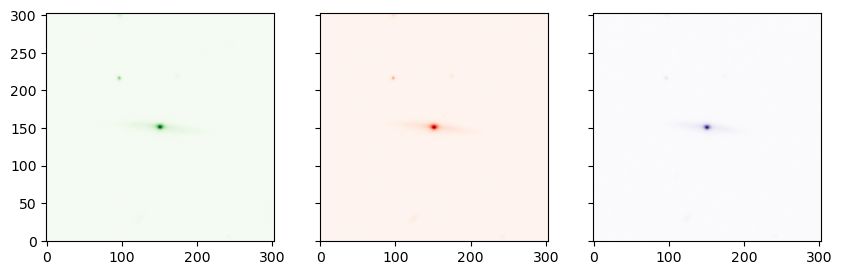

In [167]:
mg_image = ma.array(image_data[:,:,0])
mr_image = ma.array(image_data[:,:,1])
mz_image = ma.array(image_data[:,:,2])

plt.figure()
ax1=plt.subplot(131)
plt.imshow(mg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

In [168]:
# extract the image shape and coordinates for g, r, and z.
rowsg, colsg = mg_image.shape
yg, xg = np.mgrid[0:rowsg, 0:colsg]
squared_distanceg = xg**2 + yg**2

rowsr, colsr = mr_image.shape
yr, xr = np.mgrid[0:rowsr, 0:colsr]
squared_distancer = xr**2 + yr**2

rowsz, colsz = mz_image.shape
yz, xz = np.mgrid[0:rowsz, 0:colsz]
squared_distancez = xz**2 + yz**2

# flatten the images
flattened_g = np.ravel(mg_image)
flattened_r = np.ravel(mr_image)
flattened_z = np.ravel(mz_image)

# sort the indices by assosiated intensity pixel, greatest to lowest intensity
sorted_pix_g = np.argsort(flattened_g)[::-1]
sorted_pix_r = np.argsort(flattened_r)[::-1]
sorted_pix_z = np.argsort(flattened_z)[::-1]

# make a list of intensity values greatest to lowest
intlistg = flattened_g[sorted_pix_g]
intlistr = flattened_r[sorted_pix_r]
intlistz = flattened_z[sorted_pix_z]

Sorted Indices: [45904 45903 45905 ... 24284  3127  7584]
Sorted Values: [ 0.7182149   0.6669166   0.66541106 ... -0.01047646 -0.01073648
 -0.01075171]


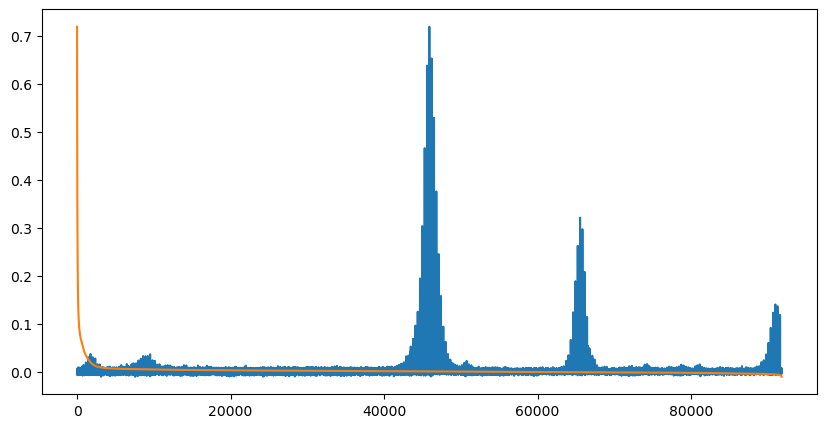

In [169]:
plt.plot(flattened_g)
plt.plot(flattened_g[sorted_pix_g])
print("Sorted Indices:", sorted_pix_g)
print("Sorted Values:", intlistg)

(151, 151)
[ 0.7182149   0.6669166   0.66541106 ... -0.01047646 -0.01073648
 -0.01075171]
[[-0.01019336 -0.00980173 -0.00895783 ... -0.00904744 -0.00964099
  -0.01047646]
 [-0.00967242 -0.00888178 -0.00872403 ... -0.00870374 -0.00887845
  -0.01011545]
 [-0.00919816 -0.00865334 -0.00820785 ... -0.00822281 -0.00865141
  -0.00932086]
 ...
 [-0.00892488 -0.0087174  -0.00822755 ... -0.00821711 -0.00868336
  -0.00916575]
 [-0.0100619  -0.00888099 -0.00872348 ... -0.00868868 -0.00882589
  -0.00956211]
 [-0.01073648 -0.00974406 -0.00915111 ... -0.00906173 -0.00986833
  -0.01075171]]
[45904 46207 45905 ...   302 91506 91808]


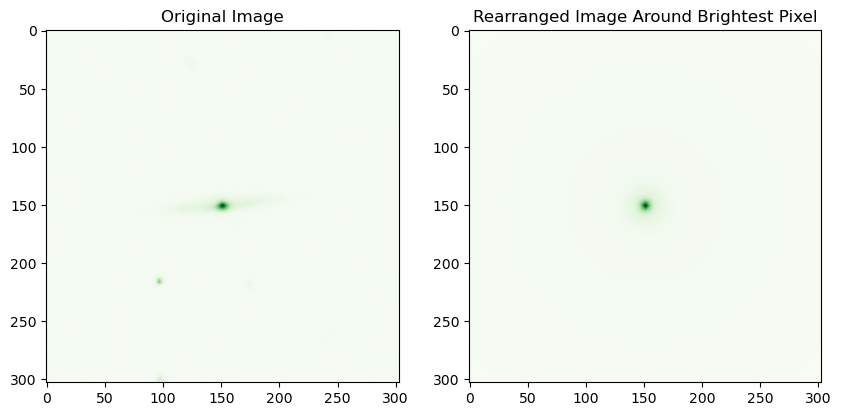

In [170]:
# find the indices of the brightest pixel in the original image
brightest_pixel_index_g = np.unravel_index(np.argmax(mg_image, axis=None), mg_image.shape)
print(brightest_pixel_index_g)

# calculate squared distances from the center (brightest pixel)
squared_distances_centeredg = (xg - brightest_pixel_index_g[1])**2 + (yg - brightest_pixel_index_g[0])**2

# sort the pixels based on squared distances from the center
sorted_distances_centeredg = np.argsort(squared_distances_centeredg.flatten())

# create a circular arrangement around the brightest pixel
arranged_imageg = np.zeros_like(mg_image)
arranged_imageg.flat[sorted_distances_centeredg] = intlistg
print(intlistg)
print(arranged_imageg)
print(sorted_distances_centeredg)

# plot the original and rearranged images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mg_image, cmap='Greens')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(arranged_imageg, cmap='Greens')
plt.title('Rearranged Image Around Brightest Pixel')

plt.show()

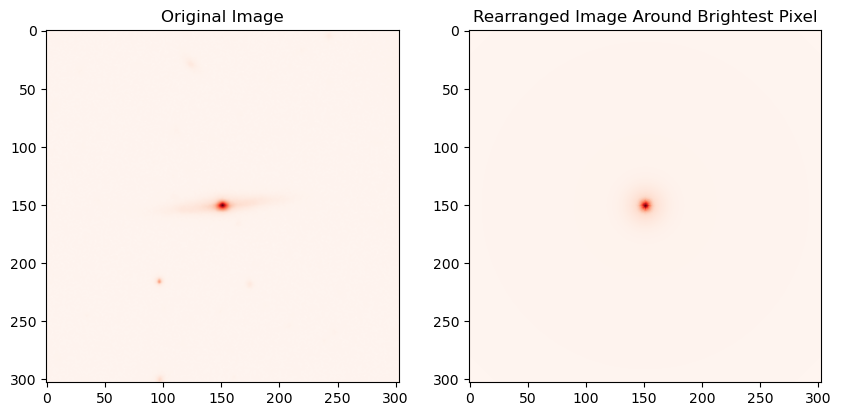

In [171]:
# find the indices of the brightest pixel in the original image
brightest_pixel_index_r = np.unravel_index(np.argmax(mr_image, axis=None), mr_image.shape)

# calculate squared distances from the center (brightest pixel)
squared_distances_centeredr = (xr - brightest_pixel_index_r[1])**2 + (yr - brightest_pixel_index_r[0])**2

# sort the pixels based on squared distances from the center
sorted_distances_centeredr = np.argsort(squared_distances_centeredr.flatten())

# create a circular arrangement around the brightest pixel
arranged_imager = np.zeros_like(mr_image)
arranged_imager.flat[sorted_distances_centeredr] = intlistr

# plot the original and rearranged images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mr_image, cmap='Reds')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(arranged_imager, cmap='Reds')
plt.title('Rearranged Image Around Brightest Pixel')

plt.show()

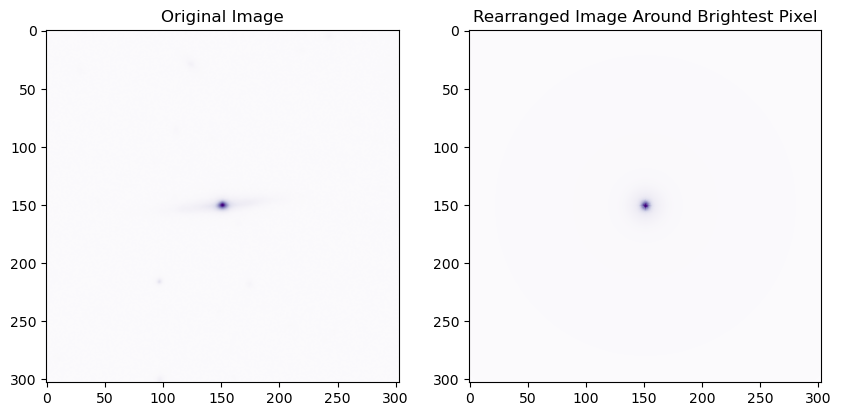

In [172]:
# find the indices of the brightest pixel in the original image
brightest_pixel_index_z = np.unravel_index(np.argmax(mr_image, axis=None), mz_image.shape)

# calculate squared distances from the center (brightest pixel)
squared_distances_centeredz = (xz - brightest_pixel_index_z[1])**2 + (yz - brightest_pixel_index_z[0])**2

# sort the pixels based on squared distances from the center
sorted_distances_centeredz = np.argsort(squared_distances_centeredz.flatten())

# create a circular arrangement around the brightest pixel
arranged_imagez = np.zeros_like(mz_image)
arranged_imagez.flat[sorted_distances_centeredz] = intlistz

# plot the original and rearranged images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mz_image, cmap='Purples')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(arranged_imagez, cmap='Purples')
plt.title('Rearranged Image Around Brightest Pixel')

plt.show()

In [173]:
print(arranged_imagez.shape)
print(mz_image.shape)

(303, 303)
(303, 303)


In [174]:
# Bits in the dict
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
    SATUR_I    = 0x4000,
    ALLMASK_I  = 0x8000,
    SUB_BLOB   = 0x10000,
)

In [175]:
# Generate bitmask to apply to image
condition = bit_mask & MASKBITS['GALAXY'] != 0
mask_ = condition.astype(int)

In [176]:
# Generate bitmask to apply to image
condition2 = mask_ & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
mask_2 = mask_ & ~condition2

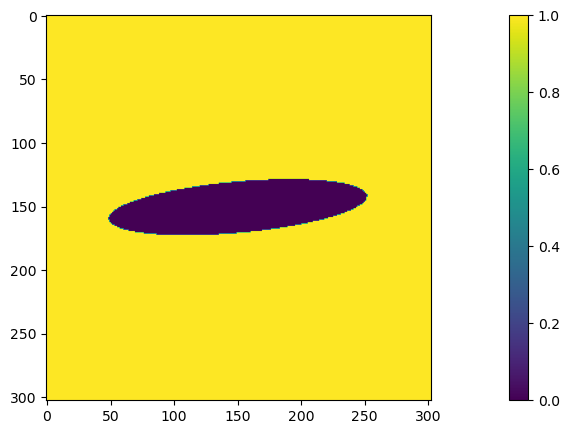

In [177]:
# Showing masked image
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(~(mask_2.astype(bool)))
plt.colorbar();

In [178]:
mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
print(f"Mask Shape: {mask.shape}")
print(f"Mask_2 Shape: {mask_2.shape}")

Mask Shape: (303, 303, 3)
Mask_2 Shape: (303, 303)


In [179]:
mimage_data = ma.array(image_data, mask=~mask)
print(f"Masked Image Shape: {mimage_data.shape}")

Masked Image Shape: (303, 303, 3)


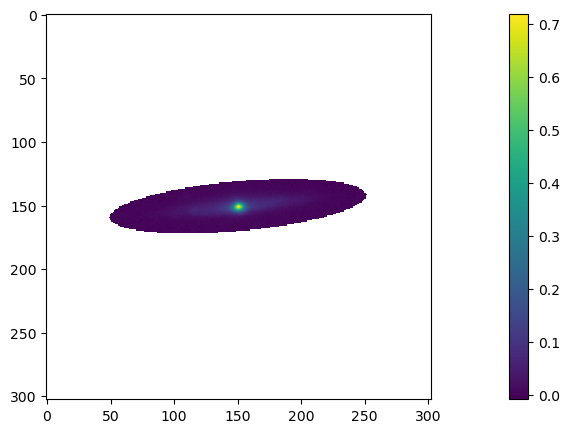

In [180]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(mimage_data[:,:,0])
plt.colorbar();

In [181]:
print(image_data.shape)
print(mr_image.shape)
print(arranged_imager.shape)
print(len(image_data))
print(len(mr_image))

(303, 303, 3)
(303, 303)
(303, 303)
303
303


In [182]:
# color images
mmg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
mmr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
mmz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

In [183]:
# Use the masks from the original images
mask_g = mmg_image.mask
mask_r = mmr_image.mask
mask_z = mmz_image.mask

# Apply masks to rearranged images
marranged_imageg = ma.array(arranged_imageg, mask=mask_g)
marranged_imager = ma.array(arranged_imager, mask=mask_r)
marranged_imagez = ma.array(arranged_imagez, mask=mask_z)

In [184]:
print(arranged_imageg.shape)
print(arranged_imager.shape)
print(arranged_imagez.shape)
print(mask.shape)
print(bit_mask.shape)

(303, 303)
(303, 303)
(303, 303)
(303, 303, 3)
(303, 303)


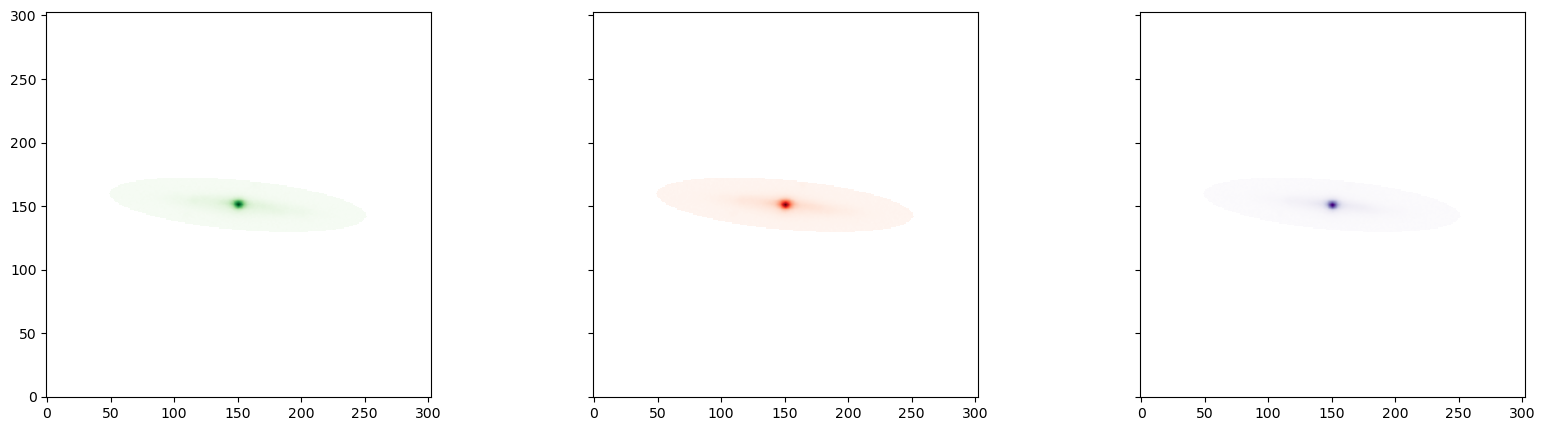

In [185]:
plt.figure()
ax1=plt.subplot(131)
plt.imshow(mmg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mmr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mmz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

In [186]:
print(marranged_imageg)
print(marranged_imager)
print(marranged_imagez)

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


In [187]:
# Check if any values in marranged_imageg are masked
any_masked_g = np.any(marranged_imageg.mask)

# Check if any values in marranged_imager are masked
any_masked_r = np.any(marranged_imager.mask)

# Check if any values in marranged_imagez are masked
any_masked_z = np.any(marranged_imagez.mask)

print(f"Any values in marranged_imageg are masked: {any_masked_g}")
print(f"Any values in marranged_imager are masked: {any_masked_r}")
print(f"Any values in marranged_imagez are masked: {any_masked_z}")

Any values in marranged_imageg are masked: True
Any values in marranged_imager are masked: True
Any values in marranged_imagez are masked: True


In [188]:
# Check if all values in marranged_imageg are masked
all_masked_g = np.all(marranged_imageg.mask)

# Check if all values in marranged_imager are masked
all_masked_r = np.all(marranged_imager.mask)

# Check if all values in marranged_imagez are masked
all_masked_z = np.all(marranged_imagez.mask)

print(f"All values in marranged_imageg are masked: {all_masked_g}")
print(f"All values in marranged_imager are masked: {all_masked_r}")
print(f"All values in marranged_imagez are masked: {all_masked_z}")

All values in marranged_imageg are masked: False
All values in marranged_imager are masked: False
All values in marranged_imagez are masked: False


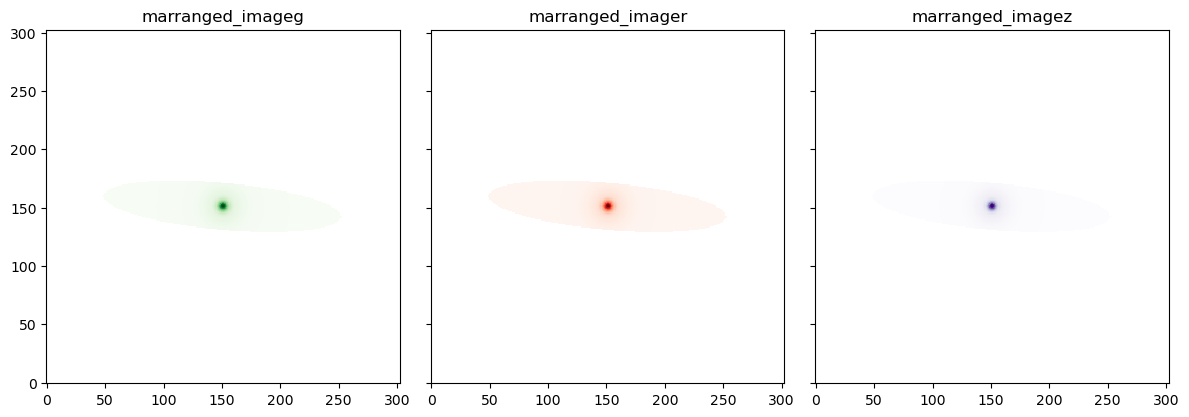

In [189]:
plt.figure(figsize=(12, 4))

# Plot for marranged_imageg
plt.subplot(131)
plt.imshow(marranged_imageg, origin='lower', cmap='Greens', interpolation='none', vmin=marranged_imageg.min(), vmax=marranged_imageg.max())
plt.title('marranged_imageg')

# Plot for marranged_imager
plt.subplot(132)
plt.imshow(marranged_imager, origin='lower', cmap='Reds', interpolation='none', vmin=marranged_imager.min(), vmax=marranged_imager.max())
plt.title('marranged_imager')
plt.tick_params('y', labelleft=False)

# Plot for marranged_imagez
plt.subplot(133)
plt.imshow(marranged_imagez, origin='lower', cmap='Purples', interpolation='none', vmin=marranged_imagez.min(), vmax=marranged_imagez.max())
plt.title('marranged_imagez')
plt.tick_params('y', labelleft=False)

plt.tight_layout()
plt.show()

Calculating Multiplicity Parameter:

$\Psi_{actual} = \sum_{i=1}^{N} \sum_{j=1,\, j \neq i}^{N} \dfrac{X_i \, X_j}{r_{ij}}$,
where the summation of the pixel fluxes Xi and Xj runs over all
N pixels in the segmentation map and rij is the distance (in pixels) between pixels i and j

$\Psi_{actual}$ is normalized by that which
would be achieved with the most compact possible rearrangement
of the flux pixels, i.e., the configuration that would require the
most ‘‘work’’ to pull apart. We rearrange the physical positions of
the N pixels of the segmentation map in a circular configuration
with the brightest pixel in the center and with pixel flux decreasing
outward with radius. Calling the distance between pixels i and j in
this rearranged map r'ij.

$\Psi_{compact} = \sum_{i=1}^{N} \sum_{j=1,\, j \neq i}^{N} \dfrac{X_i \, X_j}{r'_{ij}}$,

$\Psi = 100 \cdot \log(\dfrac{\Psi_{actual}}{\Psi_{compact}})$

In [190]:
print(f"Shape of image_data: {image_data.shape}")
print(f"Shape of mg_image: {mg_image.shape}")
print(f"Shape of mimage_data: {mimage_data.shape}")
print(type(mg_image))

Shape of image_data: (303, 303, 3)
Shape of mg_image: (303, 303)
Shape of mimage_data: (303, 303, 3)
<class 'numpy.ma.core.MaskedArray'>


In [191]:
# get the pixel coordinates for non-masked pixels
y, x = np.where(~mmg_image.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = mmg_image[y, x]

#print(rij_matrix)
#print(flux_matrix)

# apply the mask and sum the potential energy
actual_potential_energyg = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Actual Potential Energy G:", actual_potential_energyg)

# get the pixel coordinates for non-masked pixels
y, x = np.where(~marranged_imageg.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = marranged_imageg[y, x]

#print(rij_matrix)
#print(flux_matrix)

# apply the mask and sum the potential energy
compact_potential_energyg = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Compact Potential Energy G:", compact_potential_energyg)

Actual Potential Energy G: 598.3029395570811
Compact Potential Energy G: 813.8900600898884


In [192]:
# get the pixel coordinates for non-masked pixels
y, x = np.where(~mmr_image.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = mmr_image[y, x]

# apply the mask and sum the potential energy
actual_potential_energyr = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Actual Potential Energy R:", actual_potential_energyr)

# get the pixel coordinates for non-masked pixels
y, x = np.where(~marranged_imager.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = marranged_imager[y, x]

# apply the mask and sum the potential energy
compact_potential_energyr = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Compact Potential Energy R:", compact_potential_energyr)

Actual Potential Energy R: 3778.3603000257885
Compact Potential Energy R: 4695.113533474945


In [193]:
# get the pixel coordinates for non-masked pixels
y, x = np.where(~mmz_image.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = mmz_image[y, x]

# apply the mask and sum the potential energy
actual_potential_energyz = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Actual Potential Energy Z:", actual_potential_energyz)

# get the pixel coordinates for non-masked pixels
y, x = np.where(~marranged_imagez.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = marranged_imagez[y, x]

# apply the mask and sum the potential energy
compact_potential_energyz = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Compact Potential Energy Z:", compact_potential_energyz)

Actual Potential Energy Z: 16715.819297564245
Compact Potential Energy Z: 20267.216499394606


In [194]:
# calcualting the multiplicity parameter
multiplicityg = 100*(np.log10(compact_potential_energyg / actual_potential_energyg))
multiplicityr = 100*(np.log10(compact_potential_energyr / actual_potential_energyr))
multiplicityz = 100*(np.log10(compact_potential_energyz / actual_potential_energyz))

In [195]:
print("Multiplicity Parameter:", multiplicityg)
print("Multiplicity Parameter:", multiplicityr)
print("Multiplicity Parameter:", multiplicityz)

Multiplicity Parameter: 13.364460793922978
Multiplicity Parameter: 9.43427291152744
Multiplicity Parameter: 8.366643910245614
